# Лабораторная работа №1

## Задание:

In [1]:
from IPython.display import display, Markdown

with open('lab01.md', 'r') as fh:
    content = fh.read()
    
display(Markdown(content))

### К лекции №2

**Упражнение №5.0.1**  

Освойтесь с NumPy с помощью этого туториала:  

https://jakevdp.github.io/PythonDataScienceHandbook/02.00-introduction-to-numpy.html
  
Перед следующим упражнением, убедитесь что вы понимаете разницу между nparray и стандартным list!  
  
**Упражнение №5.0.2**  
Изучите Pandas - дефакто стандарт для работы с табличными (не bigdata) данными.  

https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html

https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html

https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html 
 
**Упражнение №5.1**  

Сделайте свой датафрейм на основе 2D-nparray  
Он должен поддерживать:  
* построчный индекс  
* хранить названия и порядок колонок  
* функции индексирования:  
 * iloc[i,j] - получить элемент по i-й строке j-й колонке. (i/j также могут быть slice-объектами)  
 * loc[k,z] - получить элемент по k-му значению построчного индекса z-й колонке (k может быть iterable/slice, z - iterable)  
 * [] - переопределить getitem, сделать его алиасом вашей loc-функции  
Также нужно сделать статический метод, читающий CSV:   
`your_package.read_csv(file_path, **csv_opts)`   
и возвращающий инстанс вашего датафрейма с прочитанными данными.    
Метод должен принимать параметры, настраивающие поведение чтения CSV-файла.  

**Упражнение №6.1**

Почитайте про случайный лес в [мануалах scikit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier)

Научитесь обучать лес и запускать его.  
Для хранения и передачи данных для sklearn вы должны использовать собственный датафрейм!  

**Упражнение №6.2**

Научитесь визуализировать деревья. Почитайте:

  * [sklearn.tree.export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz)
  * [How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)

**Задача №7**

Посмотрите на данные из выборки ещё раз. Обучите RF на этих данных.
Сравните RF c алгоритмами **p1_fraud**, **p2_fraud** и **p3_fraud**.

**Задача №8**

Подумайте, как с помощью RF оценивать информативность признаков?
Найдите информативные признаки. 

Сравните результаты с результатами **упражнения №1**.


## Упражнение №5.0.1

## Упражнение №5.0.2

## Упражнение №5.1

Блоки с кодом получились довольно жирными и их пришлось разбить. Приписывать импорты к конкретному блоку правильным не считаю, поэтому вынесу в отдельный блок.

In [2]:
import csv
import numpy as np

from collections.abc import Iterable as AbcIterable
from typing import Iterable, Sequence, Optional, Union

В Pandas индексация построена на декораторе `property` чтобы сохранить ее в привычно-змеином виде. Геттер `loc`'а/`iloc`'а возвращает объект, который решает как и что делать с полученными ключами/индексами для правильного доступа к вложенным в `DataFrame` данным. В случае индексов думать не нужно - пусть разбирается `np.ndarray`. В случае ключей придется подменить их все на соответствующие им индексы. Реализуем эти объекты.

In [3]:
class IdxView:
    def __init__(self, dataframe):
        """
        Integer-index view on Dataframe internal data.
        Simply forwards indices to np.ndarray with no checks whatsoever.
        
        Parameters:
            :dataframe: Dataframe
                Parent object
        """
        self.dataframe = dataframe
    
    def __getitem__(self, key):
        return self.dataframe.data[key]
    
    def __setitem__(self, key, value):
        self.dataframe.data[key] = value
        
    # TODO(Mocurin): Feels really bad. Should be a way around
    def __call__(self, *args):
        # Probably a []-get
        if len(args) == 1:
            return self.__getitem__(*args)
        # Probaly a []-set
        if len(args) == 2:
            return self.__setitem__(*args)
        raise ValueError() # TODO
    
    
class KeyView:
    def __init__(self, dataframe):
        """
        'Keyed' view on Dataframe internal data.
        Converts keys to respective indices and forwards them, to np.ndarray
        Note that contrary to usual python slices, both the start and the stop are included
        
        Parameters
            :dataframe: Dataframe
                Parent object
        """
        self.dataframe = dataframe
        
    def _lookup_key(self, key, axis=0):
        """
        Performs key lookup depending on the axis.
        Also supports np.newaxis aka None (which conviniently works for slice
        conversions too).
        
        Parameters
            :key: hashable
                Key to look up.
            :axis: [0, 1]
                A value to decide which dict to use for a look up.
        
        Returns
            :: Integer index.
            
        Raises
            :KeyError:
                1) Invalid axis (not in [0, 1]).
                2) Key is not present in a dict.
        """
        if key is None or isinstance(key, (bool, np.bool_)):
            return key
        try:
            if axis == 0:
                return self.dataframe.idx_to_loc[key]
            if axis == 1:
                return self.dataframe.col_to_loc[key]
        except KeyError as e:
            e.message = None # TODO
            raise e
        raise KeyError() # TODO
        
    def _handle_slice(self, slicing, axis=0):
        start = self._lookup_key(slicing.start, axis=axis)
        stop = self._lookup_key(slicing.stop, axis=axis)
        return slice(start, stop if stop is None else stop + 1, slicing.step)
    
    def _handle_fancy(self, array, axis=0):
        return np.vectorize(lambda x: self._lookup_key(x, axis=axis))(array)
    
    def _handle_single(self, key, axis=0):
        try:
            return self._lookup_key(key, axis=axis)
        except KeyError as e:
            e.message = None # TODO
            raise e
        
    def _axis_handle_pipeline(self, key, axis=0):
        if isinstance(key, slice):
            return self._handle_slice(key, axis=axis)
        if isinstance(key, list) or isinstance(key, np.ndarray):
            return self._handle_fancy(key, axis=axis)
        return self._handle_single(key, axis=axis)
        
    def _validate_key(self, key):
        """
        Performs key lookup for: fancy indexing, slicing, singular value
        Allows only 1D/2D indexing.
        
        Parameters
            :key: tuple of: slice, sequence, hashable
                  or one of: slice, sequence, hashable
                Structure with keys to look up.
        
        Returns
            :: key input parameter with integer indices.
            
        Raises
            :KeyError:
                Non-1D-or-2D indexing applied.
        """
        # 2D action
        if isinstance(key, tuple):
            if len(key) != 2:
                raise KeyError() # TODO
            x_key = self._axis_handle_pipeline(key[0], axis=0)
            y_key = self._axis_handle_pipeline(key[1], axis=1)
            return (x_key, y_key)
        # 1D action
        return self._axis_handle_pipeline(key, axis=0)
        
    def __getitem__(self, key):
        return self.dataframe.data[self._validate_key(key)]
    
    def __setitem__(self, key, value):
        self.dataframe.data[self._validate_key(key)] = value
    
    # TODO(Mocurin): Feels really bad. Should be a way around
    def __call__(self, *args):
        # Probably a []-get
        if len(args) == 1:
            return self.__getitem__(*args)
        # Probaly a []-set
        if len(args) == 2:
            return self.__setitem__(*args)
        raise ValueError() # TODO

Используем `KeyView` и `IdxView` вместе с `propery`. А еще скопируем методы для загрузки и выгрузки таблицы из предыдущей лабы:

In [4]:
class Dataframe:
    def __init__(self,
                 data: np.ndarray,
                 columns: Union[np.ndarray, Sequence, None] = None,
                 indices: Union[np.ndarray, Sequence, None] = None):
        """
        Two-dimensional, size-immutable table.
        
        Contains labeled axis. Provides O(1) rows & columns access via index or key.
        
        Parameters
            :data: ndarray
                Contains rows
            :columns: ndarray, sequence* or None
                Contains column labels. :columns: len is required to equal data.shape[1]
                If :columns: is None labels are filled via np.arrange on data.shape[1]
            :indices: ndarray, sequence* or None
                Contains row labels. :indices: len is required to equal data.shape[0]
                If :indices: is None labels are filled via np.arrange on data.shape[0]
            
            *sequence (vs iterable) allows __len__, making shape checks easier.
             Also removes intermidiate array creations for preserving one-time iterables entirely.
            
        Raises
            :ValueError:
                1) Columns/indices shape requirements are not satisfied
                2) Recieved non-2D array as data.
        """
        if len(data.shape) != 2:
            raise ValueError(f"2D array required. "
                             f"Recieved array of {len(data.shape)} dimensions")
        self.data = data
        x, y = data.shape
        
        def _validate_shape(seq, req_len, label: str):
            if seq is None:
                return np.arange(req_len)
            if len(seq) != req_len:
                raise ValueError(f"Actual {label}s and recieved {label}s amount vary: "
                                 f"{req_len} vs {len(seq)}")
            return np.array(seq)
        
        indices = _validate_shape(indices, x, 'row')
        columns = _validate_shape(columns, y, 'column')
        
        # Construct two-way mapping for loc & iloc internal usage
        self.col_to_loc = {col: loc for loc, col in enumerate(columns)}
        self.columns = np.array(columns)
        self.idx_to_loc = {idx: loc for loc, idx in enumerate(indices)}
        self.rows = np.array(indices)
    
    def to_md(self):
        """
        Return markdown representaion of dataframe columns & first 5 rows.
        # TODO(Mocurin): Make `display(df)` available
        """
        columns = f"|{'|'.join(self.columns)}|"
        table_spec = f"|{'|'.join([':-'] * len(self.columns))}|"
        rows = [f"|{'|'.join(row)}|" for row in self.iloc[:5]]
        return Markdown('\n'.join([columns, table_spec, *rows]))
        
    @property
    def loc(self):
        return KeyView(self)
    
    @property
    def iloc(self):
        return IdxView(self)
    
    def to_csv(self, file_path, *args, **kwargs):
        with open(file_path, 'w', newline='') as file:
            csvfile = csv.writer(file, *args, **kwargs)
            csvfile.writerow(self.columns)
            csvfile.writerows(self.data.T)
    
    @staticmethod
    def read_csv(file_path, *args, **kwargs):
        with open(file_path, 'r', newline='') as file:
            csvfile = csv.reader(file, *args, **kwargs)
            try: columns = next(csvfile)
            except StopIteration: raise RuntimeError("File is empty")
            data = list(csvfile)
            return Dataframe(np.array(data), columns)
    
    __getitem__ = loc
    __setitem__ = loc

Протестируем dataframe выгрузив в него данные из нулевой л/р.

In [5]:
df = Dataframe.read_csv("./fixed_data.csv", delimiter=';')
display(df.to_md())

|EVENT_TIME|USER_HASH|EVENT_TYPE|EVENT_TYPE_EX|AMOUNT|X2|X3|X4|X5|X6|X9|X10|X11|X12|X13|X14|X15|X16|X17|X18|X22|X23|X24|X26|COOKIE|p1_Fraud|p2_Fraud|p3_Fraud|p4_Fraud|p5_Fraud|CLASS|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|2015-12-15 01:09:38|7215be4441716d2f96d932ecf20e324145933912|PAYMENT|CLOSE_ACCOUNT|97207.0500|1940-06-02 00:00:00|bb64-:2c7eeb2a151:f01a1461-|f7fe0766c3|8251ac24fc|a0e4def3e5|0|0|Windows|RUB|0|0|-754|Chrome::47|491|898|12.0|80.83.236.10|Petropavlovsk|/PhizIC/private/payments/confirm.do|146521096|0.2608|0.4130|0.2845|0.3043|0.3130|G|
|2015-12-15 01:18:24|62f4b9133f70c5d06b8789182e7728e7aa0dd7f9|PAYMENT|RURPAYJURSB|500|1981-07-11 00:00:00|f9b1-:2ea1a82a151:3b9c59-|790568bcfa|e7d835c559|a0e4def3e5|0|0|Windows|RUB|0|0|-1099|Chrome::48|-879|0|4.0|178.187.133.68|Barnaul|/PhizIC/private/payments/confirm.do|17569041|0.1233|0.2480|0.1345|0.2493|0.1480|G|
|2015-12-15 01:19:06|62f4b9133f70c5d06b8789182e7728e7aa0dd7f9|PAYMENT|RURPAYJURSB|100|1981-07-11 00:00:00|f036-:ab3f2e2a151:8048964-|790568bcfa|e7d835c559|a0e4def3e5|0|0|Windows|RUB|0|0|-1101|Chrome::48|-875|-1522|4.0|178.187.133.68|Barnaul|/PhizIC/private/async/payments/confirm.do|10964495|0.0433|0.1520|0.0473|0.2173|0.0520|G|
|2015-12-15 01:22:07|7215be4441716d2f96d932ecf20e324145933912|PAYMENT|RURPAYMENT||1940-06-02 00:00:00|5091-:2ea1a82a151:3b9c59-|f7fe0766c3|8251ac24fc|a0e4def3e5|0|0|Windows|RUB|0|0|-778|Chrome::47|0|0|12.0|80.83.236.10|Petropavlovsk|/PhizIC/private/async/payments/confirm.do|146521096|0.2800|0.4360|0.1360|0.3120|0.3360|G|
|2015-12-15 01:23:01|62f4b9133f70c5d06b8789182e7728e7aa0dd7f9|PAYMENT|RURPAYJURSB|300|1981-07-11 00:00:00|063-:cc0fe32a151:0285f4b4|790568bcfa|e7d835c559|a0e4def3e5|0|0|Windows|RUB|0|0|-1099|Chrome::48|-879|898|4.0|178.187.133.68|Barnaul|/PhizIC/private/async/payments/confirm.do|10964495|0.3117|0.4740|0.3400|0.3247|0.3740|G|

Протестируем это дело:

Получим первые 11 рядов с колонками от `p1_Fraud` до `p5_Fraud` включительно при помощи loc.

In [6]:
df.loc[:10, 'p1_Fraud':'p5_Fraud']

array([['0.2608', '0.4130', '0.2845', '0.3043', '0.3130'],
       ['0.1233', '0.2480', '0.1345', '0.2493', '0.1480'],
       ['0.0433', '0.1520', '0.0473', '0.2173', '0.0520'],
       ['0.2800', '0.4360', '0.1360', '0.3120', '0.3360'],
       ['0.3117', '0.4740', '0.3400', '0.3247', '0.3740'],
       ['0.1758', '0.3110', '0.1918', '0.2703', '0.2110'],
       ['0.3450', '0.4450', '0.5864', '0.4150', '0.6450'],
       ['0.1242', '0.2490', '0.1355', '0.2497', '0.1490'],
       ['0.0642', '0.1770', '0.0700', '0.2257', '0.0770'],
       ['0.0758', '0.1910', '0.0827', '0.2303', '0.0910'],
       ['0.0733', '0.1880', '0.0800', '0.2293', '0.0880']], dtype='<U41')

Получим колонку 'CLASS' при помощи loc.

In [7]:
df.loc[:, 'CLASS']

array(['G', 'G', 'G', ..., 'F', 'F', 'F'], dtype='<U41')

Получим все колонки содержащие `Fraud`.

In [8]:
df[:, ['Fraud' in col for col in df.columns]]

array([['0.2608', '0.4130', '0.2845', '0.3043', '0.3130'],
       ['0.1233', '0.2480', '0.1345', '0.2493', '0.1480'],
       ['0.0433', '0.1520', '0.0473', '0.2173', '0.0520'],
       ...,
       ['0.6890', '0.7890', '0.8991', '0.9890', '0.9890'],
       ['0.6900', '0.7900', '0.9000', '0.9900', '0.9900'],
       ['0.6940', '0.7940', '0.9036', '0.9940', '0.9940']], dtype='<U41')

Используя fancy-indexing получим первую, третью и 10-ю колонки

In [9]:
df.iloc[:, [1, 3, 10]]

array([['7215be4441716d2f96d932ecf20e324145933912', 'CLOSE_ACCOUNT', '0'],
       ['62f4b9133f70c5d06b8789182e7728e7aa0dd7f9', 'RURPAYJURSB', '0'],
       ['62f4b9133f70c5d06b8789182e7728e7aa0dd7f9', 'RURPAYJURSB', '0'],
       ...,
       ['87f33b43c12b14815b08c724e306bb5b59ee1c56', 'RURPAYMENT', '0'],
       ['f1c4e08219c20f829b9ff07656fb39a0186727f0', 'RURPAYJURSB', '0'],
       ['f1c4e08219c20f829b9ff07656fb39a0186727f0', 'RURPAYJURSB', '0']],
      dtype='<U41')

Получим те хэши, где `p1_Fraud` > 0.66

In [10]:
df.loc[df[:, 'p1_Fraud'].astype('float') > 0.66, ['USER_HASH', 'p1_Fraud']]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (7837,) (2,) 

Кажется это уже загоны numpy. Не уверен что могу это пофиксить

## Упражнение 6.1

Нагенерируем игрушечных данных:

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=42, cluster_std=2.0)

Визуализируем их:

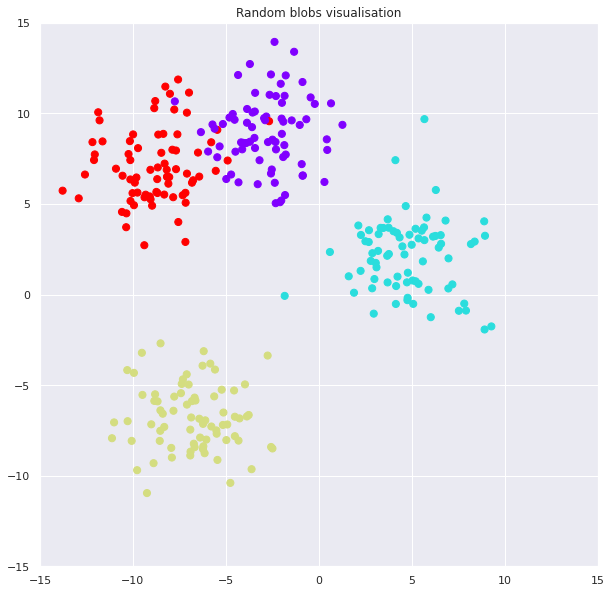

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.figure(figsize=(10, 10))
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.title("Random blobs visualisation")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Обучим классификатор:

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X, y)

Визуализируем дерево при помощи graphviz:

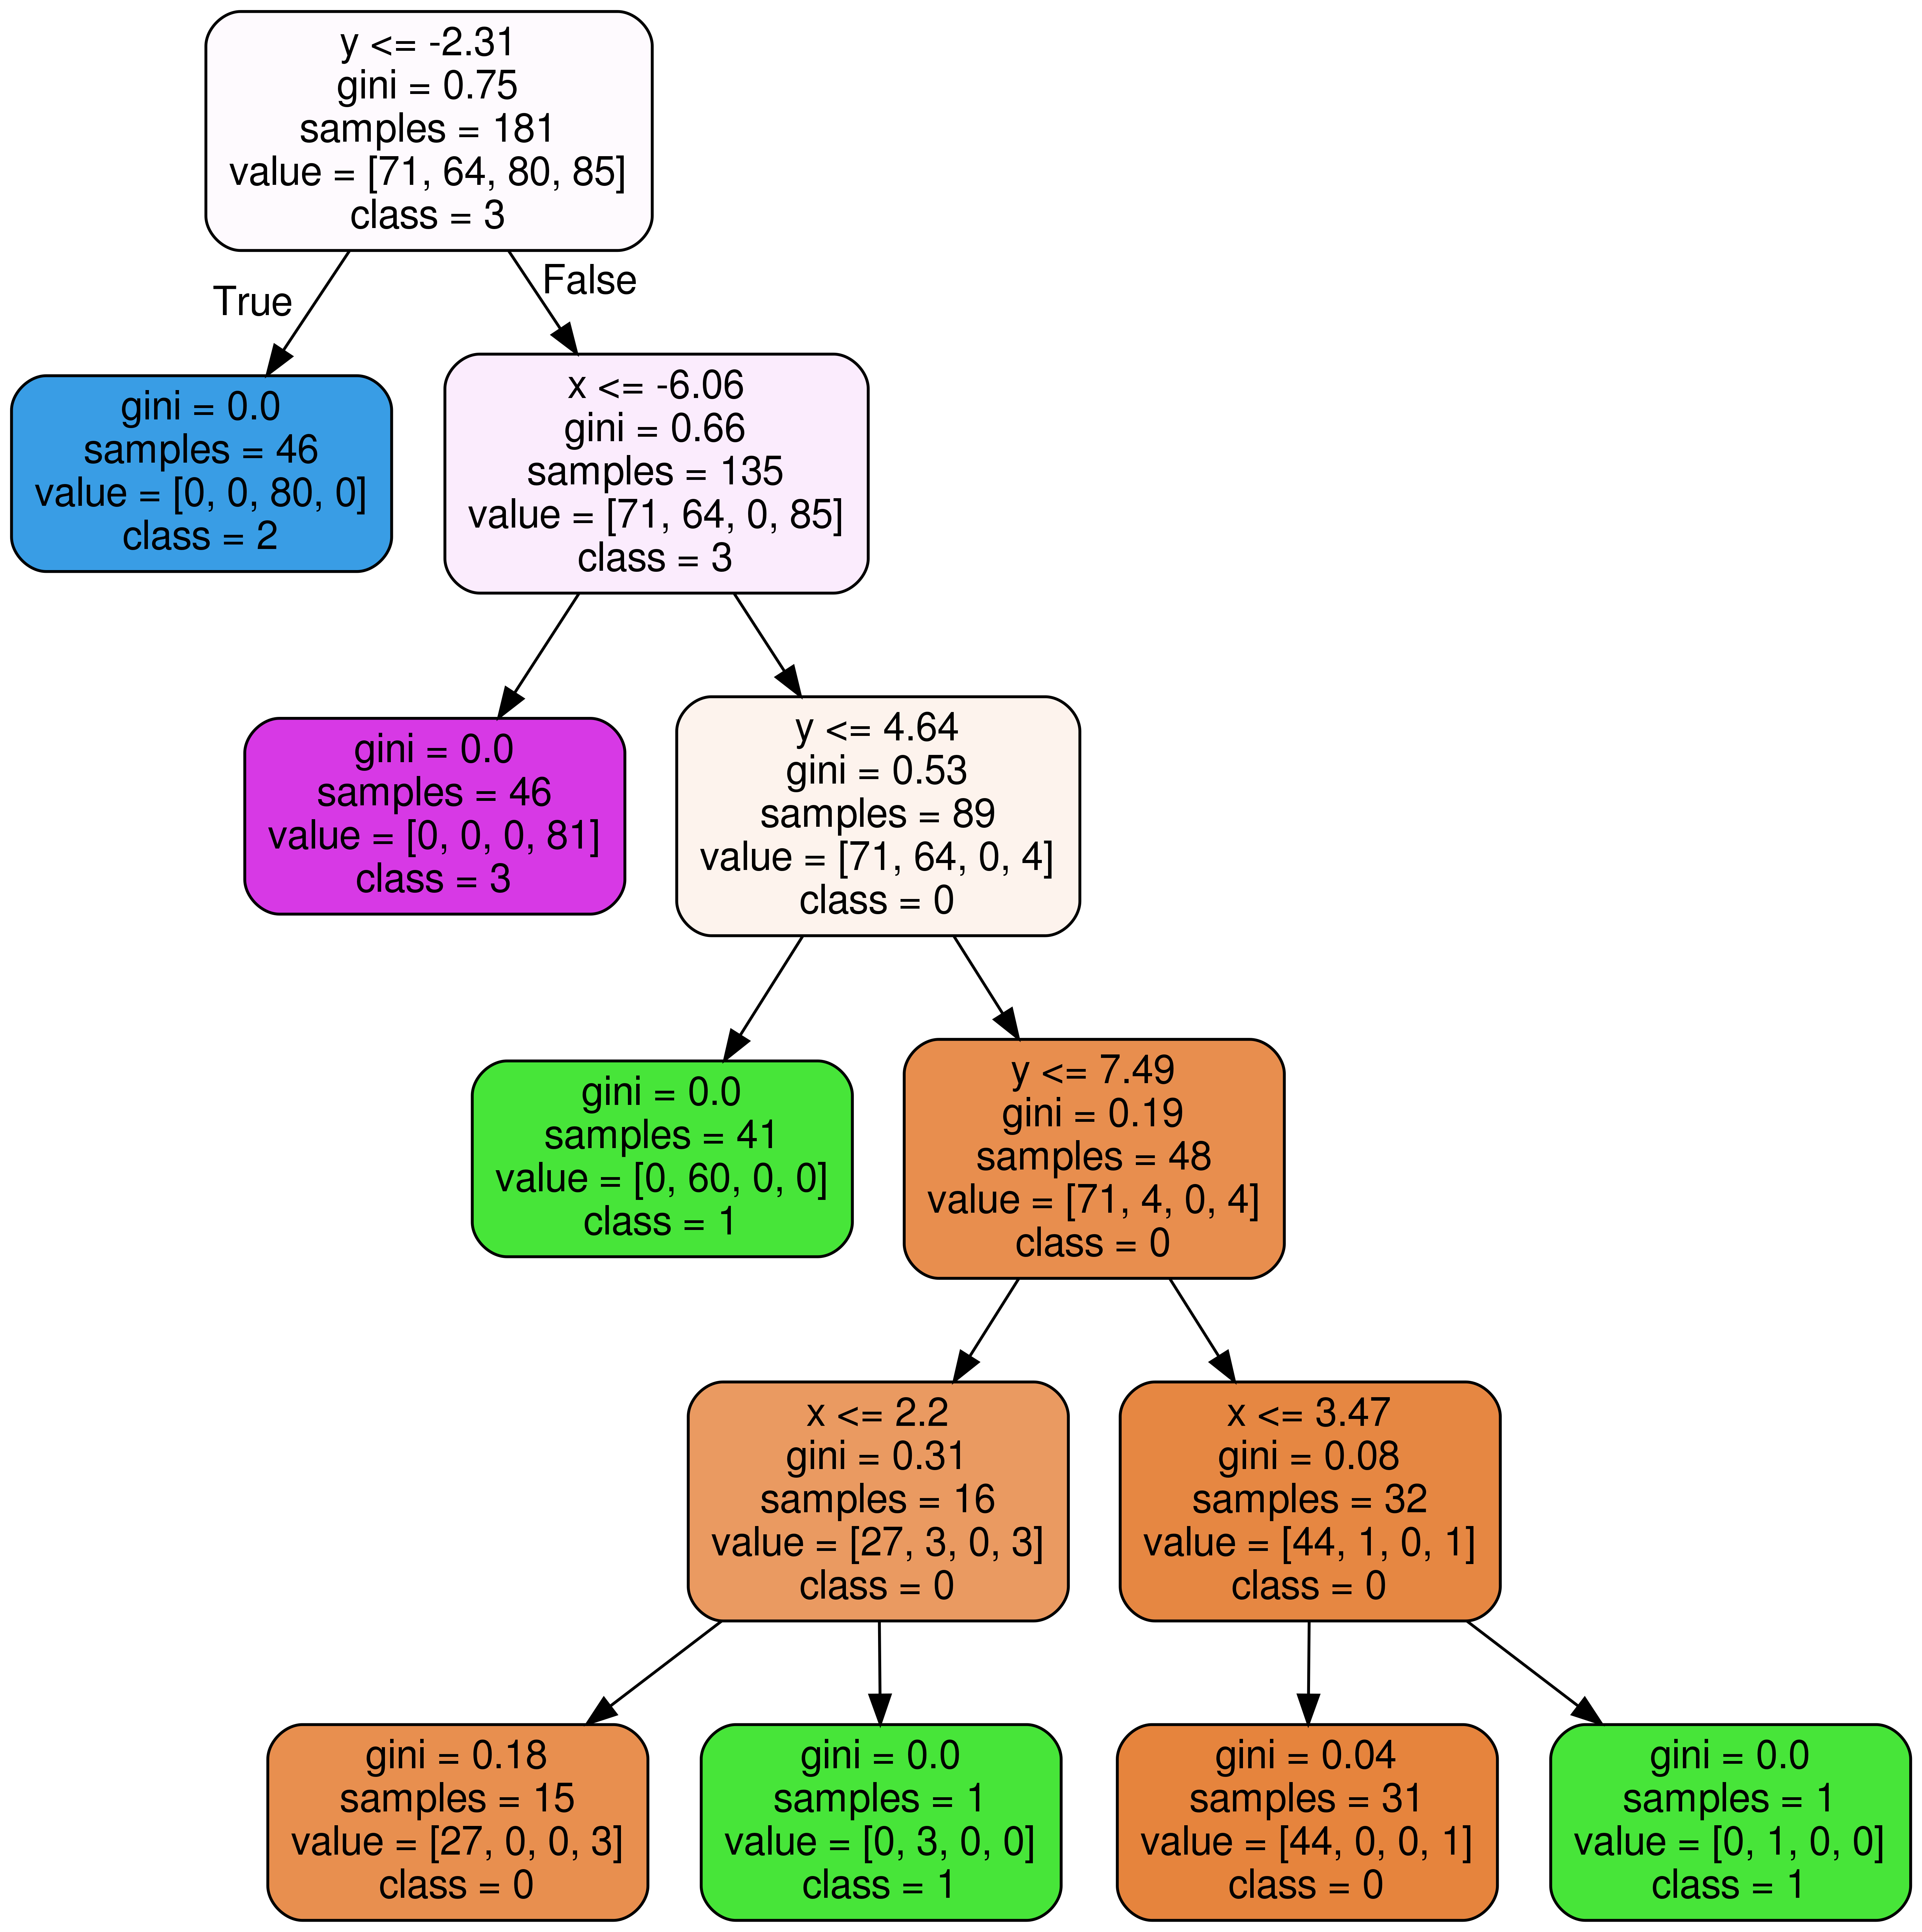

In [48]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

def display_tree(tree, *args, **kwargs):
    export_graphviz(tree, out_file='tree.dot', *args, **kwargs)
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    display(Image(filename = 'tree.png'))
    
display_tree(forest.estimators_[0], feature_names = ('x', 'y'),
             class_names = list(str(i) for i in range(4)),
             rounded = True, proportion = False, 
             precision = 2, filled = True)

Визуализируем разбиение пространства признаков:

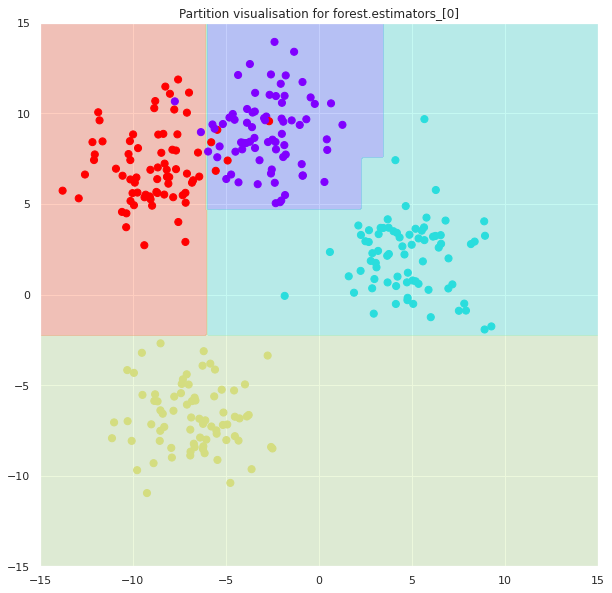

In [75]:
def visualize_partition(X, y, tree, **kwargs):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50,
               clim=(y.min(), y.max()),
               zorder=3,
               **kwargs)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    counturs = ax.contourf(xx, yy, z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           zorder=1,
                           **kwargs)
    ax.set(xlim=xlim, ylim=ylim)

plt.figure(figsize=(10,10))
plt.title("Partition visualisation for forest.estimators_[0]")
plt.xlim(-15, 15)
plt.ylim(-15, 15)
visualize_partition(X, y, forest.estimators_[0], cmap='rainbow')